In [1]:
import functools
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [3]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [4]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, "r").read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: "anime_id", 9: "my_score"}, axis=1)
    df["username"] = username
    df["anime_id"] = df["anime_id"].astype(int)
    df["my_score"] = df["my_score"].astype(int)
    df["username"] = df["username"].astype(str)
    df = df.loc[lambda x: x["my_score"] != 0]
    df = df.reset_index(drop=True)
    return df


def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x["username"] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [5]:
filtered_df = add_user(filtered_df, "user_profiles/Fro116.xml", "Fro116")

In [6]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [7]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [8]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [9]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on="anime_id")
    adj_cos_corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["normalized_score_x"], x["normalized_score_y"])
    )
    adj_cos_corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["normalized_score"], x["normalized_score"]))
    )
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame(
        (adj_cos_corr_numerator / adj_cos_corr_denom), columns=["corr"]
    )
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [10]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [11]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605473,0.605473
karthiga,59,7,0.040203,-0.059898,-0.474166,-0.474166
karthiga,74,7,0.316283,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227338,-0.059898,-0.206624,-0.206624


In [12]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, normalize_variance
):

    # Should we normalize by variance?
    # Note that normalize_variance=True modifies the data
    if normalize_variance:
        user_stds = (
            is_df.groupby("username")[["normalized_score"]]
            .std()
            .rename({"normalized_score": "user_std"}, axis=1)
        )
        is_df = is_df.merge(user_stds, on="username")
        is_df["normalized_score"] /= is_df["user_std"]
        is_df = is_df.drop("user_std", axis=1)

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.sort_values(by="similarity").dropna()
    corrs = corrs.drop(recommendee)  # makes insample score more meaningful

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (
            is_df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on="username")
        ).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "normalize_variance": normalize_variance,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [13]:
%%time
from tqdm import tqdm

recommendee = "Fro116"
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(len(filtered_df)) / np.log(base)) + 1)
] + [len(filtered_df)]
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies because setting normalize_variance=True modifies the data
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, True
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, False
        )
    )

100%|██████████| 10/10 [9:16:34<00:00, 3339.49s/it] 

CPU times: user 5h 54min 51s, sys: 1h 37min 17s, total: 7h 32min 9s
Wall time: 9h 16min 36s


In [14]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [15]:
allerrors

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
0,0.008902,1.567559,1.0,1.0,0.000000,1.731232
1,0.008902,1.567559,1.0,1.0,0.000000,1.731232
2,0.032641,1.539400,2.0,1.0,0.026316,1.711959
3,0.032641,1.539400,2.0,1.0,0.026316,1.711959
4,0.142433,1.512222,4.0,1.0,0.157895,1.690107
...,...,...,...,...,...,...
1035,0.923077,0.806093,11863283.0,0.0,0.891892,1.111266
1036,0.923077,0.806093,16777216.0,0.0,0.891892,1.111266
1037,0.923077,0.806093,23726566.0,0.0,0.891892,1.111266
1038,0.923077,0.806093,33554432.0,0.0,0.891892,1.111266


In [16]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "normalize_variance"])

In [17]:
wide_data.loc[lambda x: x.normalize_variance == True, "variable"] = (
    "normalized_" + wide_data.loc[lambda x: x.normalize_variance == True, "variable"]
)

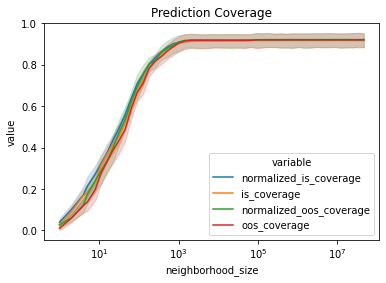

In [18]:
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

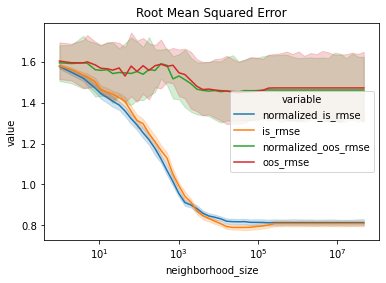

In [19]:
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [20]:
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
)

is_coverage   is_rmse  oos_coverage  \
normalize_variance neighborhood_size                                        
0.0                32768.0               0.917329  0.789738      0.916999   
                   23170.0               0.917329  0.789720      0.916999   
                   46340.0               0.917625  0.789739      0.916999   
                   65536.0               0.919106  0.790504      0.916999   
1.0                32768.0               0.917329  0.817484      0.916999   
...                                           ...       ...           ...   
0.0                4.0                   0.166857  1.534174      0.119986   
1.0                1.0                   0.039663  1.577343      0.027027   
0.0                2.0                   0.089196  1.561761      0.058748   
                   5.0                   0.183468  1.526467      0.135775   
                   1.0                   0.027237  1.579364      0.010811   

                                      oos_rmse  
normalize_variance neighborhood_size            
0.0                32768.0            1.448625  
                   23170.0            1.451758  
                   46340.0            1.451846  
                   65536.0            1.452821  
1.0                32768.0            1.452951  
...                                        ...  
0.0                4.0                1.594383  
1.0                1.0                1.594533  
0.0                2.0                1.595024  
                   5.0                1.599367  
                   1.0                1.603097  

[100 rows x 4 columns]